In [1]:
import sys
#sys.path.append('../alibi/explainers/counterfactual/')
import pandas as pd
import numpy as np
from scipy.spatial.distance import cityblock
from scipy.optimize import minimize
from sklearn import svm, datasets
from sklearn.model_selection import cross_val_score
#import counterfactuals
from matplotlib.pyplot import imshow
import importlib
%matplotlib inline

# Iris

In [2]:
iris = datasets.load_iris()
X_train, y_train = iris.data, iris.target
clf = svm.SVC(gamma='scale',probability=True)
clf.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [3]:
X=X_train[42:43]

In [4]:
pred_class=clf.predict_proba(X).argmax()
initial_instace = np.random.permutation(X_train)[0]
clf.predict_proba(X)


array([[0.97580458, 0.01278708, 0.01140834]])

### Minimization

In [ ]:
X = X_train[1]
X_0 = X_train[2]
func = _define_func(clf.predict_proba,X,target_class=0)
#gradients=_calculate_funcgradx(func,X)
gradients = _calculate_watcher_grads(X,func,_mock_metric,X_0,0.1,0.5,1)
gradients

---

# Mnist

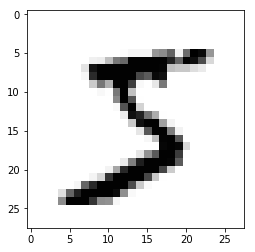

In [5]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
imshow(x_train[0],cmap='Greys')

In [6]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])
initial_instace = np.random.permutation(x_train)[:1]

input = tf.keras.Input(shape=(28,28,1),name='input_part')
out=tf.keras.layers.Conv2D(32, (5, 5), activation='relu')(input)
out=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(out)
out=tf.keras.layers.Dropout(0.2)(out)
out=tf.keras.layers.Flatten()(out)
out=tf.keras.layers.Dense(128, activation='relu')(out)
out=tf.keras.layers.Dense(10,activation='softmax')(out)

model = tf.keras.Model(input, out)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0405 11:25:22.608538 140735836812160 deprecation.py:506] From /Users/Gigio/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1257: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


x_train shape: (60000, 28, 28, 1)
Number of images in x_train 60000
Number of images in x_test 10000


In [7]:
model.fit(x_train,tf.keras.utils.to_categorical(y_train),epochs=2)

Epoch 1/2
60000/60000 [==============================] - 15s 250us/sample - loss: 0.1453 - acc: 0.9563
Epoch 2/2
60000/60000 [==============================] - 16s 264us/sample - loss: 0.0514 - acc: 0.9840


### Minimization

In [139]:
from time import time

def _define_func(predict_fn,x,target_class='same'):
    
    x_shape_batch_format = (1,)+x.shape
    if target_class=='same':
        target_class=np.argmax(predict_fn(x.reshape(x_shape_batch_format)),axis=1)[0]

    def func(x,target_class=target_class):
        proba = predict_fn(x)[:,target_class]
        return proba
    return func

def _calculate_funcgradx(func,x,epsilon=1):
    
    x_shape = x.shape
    
    x=x.flatten() 
    X_plus, X_minus = [],[]
    t_0 = time()
    for i in range(len(x)):
        x_plus,x_minus = np.copy(x),np.copy(x)
        x_plus[i]+=epsilon
        x_minus[i]-=epsilon
        x_plus,x_minus = x_plus.reshape(x_shape),x_minus.reshape(x_shape)
        X_plus.append(x_plus)
        X_minus.append(x_minus)        
    
    deltat_1 = time() - t_0
    t_1 = time()
    X_plus=np.asarray(X_plus)
    X_minus=np.asarray(X_minus)
    gradients = (func(X_plus) - func(X_minus))/(2*epsilon)

    deltat_2 = time() - t_1
    t_2 = time()
    deltat_tot = t_2 - t_0

    return gradients

In [140]:
def _mock_metric(x,x_0):
    return 1

def l1_metric(x,x_0):
    pass
    

In [167]:
from scipy.spatial.distance import cityblock
def _define_loss_metric(metric, x_0):
 
    def loss_metric(x):
        batch_size = x.shape[0]
        distances = []
        for i in range(batch_size):
            distances.append(metric(x[i].flatten(),x_0.flatten()))
        return np.asarray(distances)
    
    return loss_metric

def _calculate_watcher_grads(x, func, metric, x_0, target_probability, _lam, _norm, 
                             epsilon_func=1.0, epsilon_metric=1e-10):
    
    x_shape_batch_format = (1,)+x.shape
    
    preds = func(x.reshape(x_shape_batch_format))
    loss_metric = _define_loss_metric(metric,x_0)
    
    funcgradx = _calculate_funcgradx(func,x,epsilon=epsilon_func)
    metricgradx = _calculate_funcgradx(loss_metric,x,epsilon=epsilon_metric)
    gradients_0 = (1 - _lam) * 2 * (preds[0] - target_probability) * funcgradx
    gradients_1 = _lam * _norm * metricgradx
    
    gradients = gradients_0 + gradients_1
    return gradients

In [142]:
X_init = x_train[0]
X_0 = x_train[0]
func = _define_func(model.predict,X,target_class=1)
#gradients=_calculate_funcgradx(func,X)
gradients = _calculate_watcher_grads(X,func,_mock_metric,X_0,0.1,0.5,1)

In [143]:
gradients

array([ 2.60833644e-09,  2.93360336e-09,  7.45308704e-09,  6.00346395e-09,
        4.34297709e-09,  3.65523656e-09,  1.11110310e-09,  1.09282372e-09,
       -2.14148310e-10, -6.38538389e-10,  1.05429254e-09,  3.99596467e-10,
        1.75764492e-09,  1.39052869e-09, -2.03119299e-10, -9.52669610e-10,
       -9.42369627e-10, -7.66316233e-10, -9.15472864e-10, -6.19133522e-10,
        7.58376695e-10,  1.24273780e-09, -1.78213155e-09, -2.01022932e-09,
       -1.89720084e-09, -1.30444822e-09, -1.81747672e-10, -2.44101850e-10,
        4.23249791e-09,  4.28239755e-09,  1.04430304e-08,  8.94552166e-09,
        7.31111260e-09,  7.82947307e-09,  5.96002714e-09,  4.98115993e-09,
        1.83550308e-09,  1.37319010e-11,  1.49662227e-09,  4.12218509e-10,
        2.17759277e-09, -3.55078272e-10,  3.40036159e-11,  8.24027721e-11,
       -2.17340479e-09, -1.80121107e-09,  3.97497535e-10,  1.48548385e-09,
        2.19642060e-09,  3.78763154e-09, -2.98702590e-10, -3.47509244e-09,
       -3.50806229e-09, -

In [186]:
def minimize_watcher(predict_fn, metric, x_i, x_0, target_class, target_probability, 
                     epsilon_func=5, epsilon_metric=0.1, maxiter=50, 
                     initial_lam=0, lam_step=0.001, final_lam=1, lam_how='adiabatic',
                     norm=1, lr=50):
    
    x_shape = x_i.shape
    x_shape_batch_format = (1,)+x_i.shape
    func = _define_func(predict_fn,x_0,target_class=target_class)
    for i in range(maxiter):
        if lam_how == 'fixed':
            _lam = initial_lam
        elif lam_how == 'adiabatic':
            _lam = (i / maxiter) * (final_lam - initial_lam)
        gradients = _calculate_watcher_grads(x_i,func,metric,x_0,target_probability,
                                             _lam, norm, 
                                             epsilon_func=epsilon_func,
                                             epsilon_metric=epsilon_metric)

        x_i = (x_i.flatten() - lr * gradients).reshape(x_shape)
        if i % 50 == 0:
            print(_lam)
            print(target_class,predict_fn(x_i.reshape(x_shape_batch_format))[:,target_class])
    return x_i

In [191]:
x_min = minimize_watcher(model.predict, cityblock, X_init, X_0, 0, 1.0,
                         initial_lam=0, final_lam=0.0001, lam_how='adiabatic',
                         epsilon_func=5, lr=20, maxiter=1000)


0.0
0 [4.3529795e-08]
5e-06
0 [4.723691e-08]
1e-05
0 [5.786685e-08]
1.5e-05
0 [0.9999993]
2e-05
0 [0.99999905]
2.5e-05
0 [0.99999857]
3e-05
0 [0.99999785]
3.5e-05
0 [0.9999964]
4e-05
0 [0.9999931]
4.5e-05
0 [0.99998593]
5e-05
0 [0.9999709]
5.500000000000001e-05
0 [0.99994004]
6e-05
0 [0.9998746]
6.500000000000001e-05
0 [0.9997532]
7e-05
0 [0.9995758]
7.500000000000001e-05
0 [0.99937063]
8e-05
0 [0.99916506]
8.5e-05
0 [0.99900347]
9e-05
0 [0.99888223]
9.5e-05
0 [0.9989003]


[[4.3489170e-08 3.4928323e-07 2.5878185e-08 9.0577364e-02 2.9323644e-09
  9.0940332e-01 8.1226119e-07 4.3899016e-07 6.6380394e-06 1.0993484e-05]]


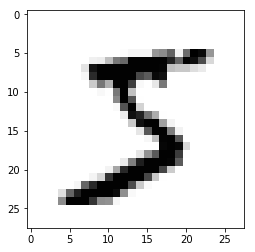

In [192]:
print(model.predict(X_0.reshape((1,)+x_min.shape)))
imshow(X_0.reshape(28,28),cmap='Greys')

[[9.9891865e-01 3.7000189e-07 4.5676461e-05 5.2607766e-06 1.1919241e-06
  2.2251972e-05 9.2564642e-06 7.1705371e-04 2.7968566e-04 6.0126808e-07]]


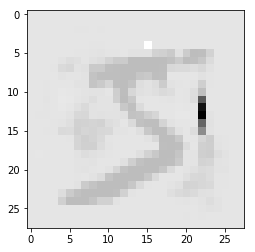

In [193]:
print(model.predict(x_min.reshape((1,)+x_min.shape)))
imshow(x_min.reshape(28,28),cmap='Greys')

In [185]:
np.argmax(model.predict(X.reshape((1,)+x_min.shape)),axis=1)[0]

5